<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/Assignment_Interpretable_ML_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](
https://github.com/ag826/AIPI590_XAI_F25/blob/main/Assignment_Interpretable_ML_II.ipynb)


# Assignment - Interpretable ML II
**Adil Keku Gazder**

**ag825@duke.edu**

**For AIPI 590 - XAI, Fall 2025**

**Duke University**

https://colab.research.google.com/drive/1VM6rt1xVf9_7DBfhbGrV51gLvrA1Eg0b


For a Wine dataset, we use physiochemical characteristics to try and model the grade of the wine. We use PDP, ICE and ALE plots and analyze the findings from these plots.

### **Installing required packages**

In [110]:
!pip install ucimlrepo
!pip install pycebox alibi

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE
from pycebox.ice import ice

import warnings
warnings.filterwarnings('ignore')


In [112]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)
df = wine_quality.data.original

## **1. Exploratory Data Analysis**

Code to get a better understanding of the dataset that we are working with, including a descripitive overview, samples and null values present in each column.

We also do a tad bit of preprocessing, including grouping numeric and categoric (dtype objects) columns together, along with visualizing our outcome variable (Churn against categorical variables).

In [113]:
print("#####################################################")
print("--- Shape Info ---")
print("#####################################################")
print("")
print(df.shape)
print("")
print("#####################################################")
print("--- Initial Data Info ---")
print("#####################################################")
print("")
df.info()
print("")
print("#####################################################")
print("--- First 5 Rows of Data ---")
print("#####################################################")
print("")
print(df.head())
print("")
print("#####################################################")
print("--- Null values of each column ---")
print("#####################################################")
print("")
print(df.isnull().sum())
print("")
print("#####################################################")
print("--- Data types of each column ---")
print("#####################################################")
print("")
print(df.dtypes)


#####################################################
--- Shape Info ---
#####################################################

(6497, 13)

#####################################################
--- Initial Data Info ---
#####################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  a

The dataset is complete, containing 6,497 observations and 13 columns with no missing values, making it immediately ready for analysis. It consists mainly of continuous numerical variables (wine chemistry metrics), one integer quality score, and a single categorical “color” column distinguishing wine types.

From the EDA above, we note a significant class imbalance exists in our dataset. To workaround this problem, we bucket the outcome variable (quality) into buckets of low, medium and high. Since 'Quality' is an ordinal variable, this will work well and improve the model's performance.

We also clean up the column names and create the test/train splits

In [114]:
df['quality_category'] = pd.cut(
    df['quality'],
    bins=[0, 5, 7, 10],  # boundaries
    labels=['low', 'medium', 'high']
)

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df = pd.get_dummies(df, columns=['color'], drop_first=True)

X = df.drop(columns=['quality', 'quality_category'])
y = df['quality_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm


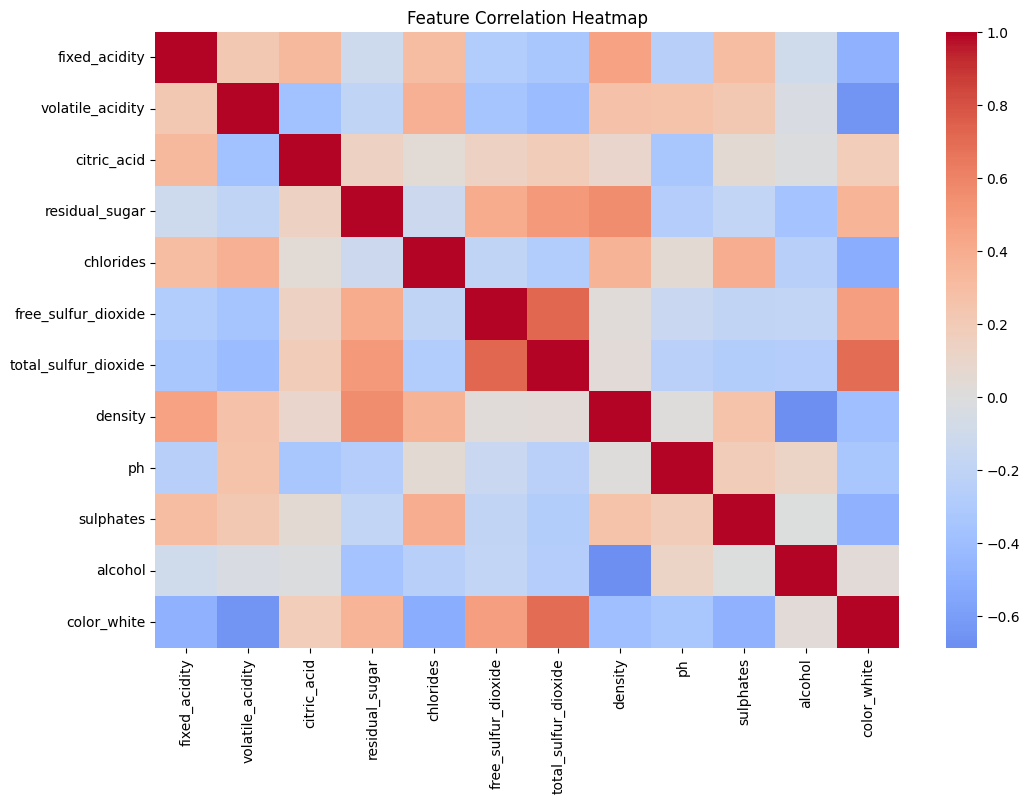

In [115]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns=['quality','quality_category']).corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


The one hot encoded 'color_white' variable has some negative correlations with several features, telling us that chemical differences between red and white wines exist as expected.

Most feature relationships are weak to moderate, showing us that many variables provide unique information without strong overlap.

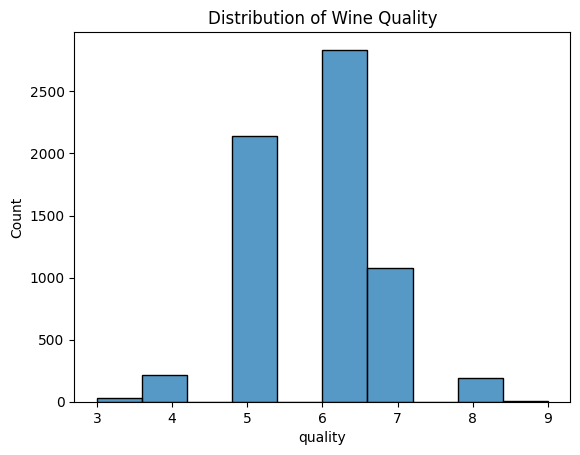

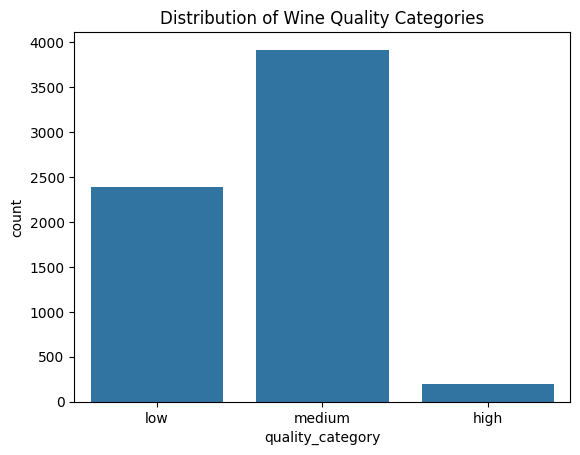

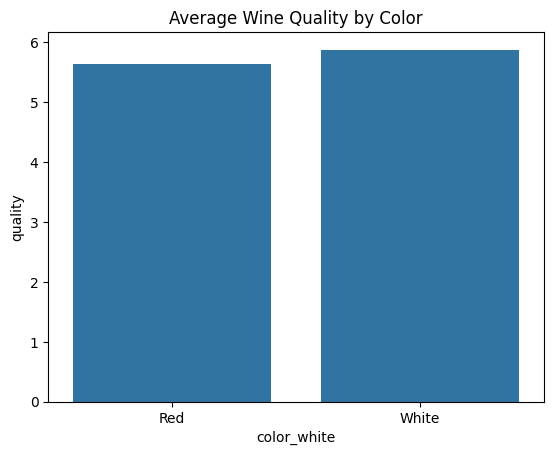

In [116]:

sns.histplot(df['quality'], bins=10, kde=False)
plt.title("Distribution of Wine Quality")
plt.show()

sns.countplot(x=y)
plt.title("Distribution of Wine Quality Categories")
plt.show()

sns.barplot(x="color_white", y="quality", data=df, ci=None)
plt.xticks([0, 1], ["Red", "White"])
plt.title("Average Wine Quality by Color")
plt.show()


# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm


## **2. Model Fit and Analysis**

Fitting the RF model as a classifier and showing the confusion matrix and feature importance map.

              precision    recall  f1-score   support

        high       1.00      0.47      0.64        40
         low       0.80      0.73      0.76       477
      medium       0.82      0.89      0.85       783

    accuracy                           0.82      1300
   macro avg       0.87      0.70      0.75      1300
weighted avg       0.82      0.82      0.81      1300



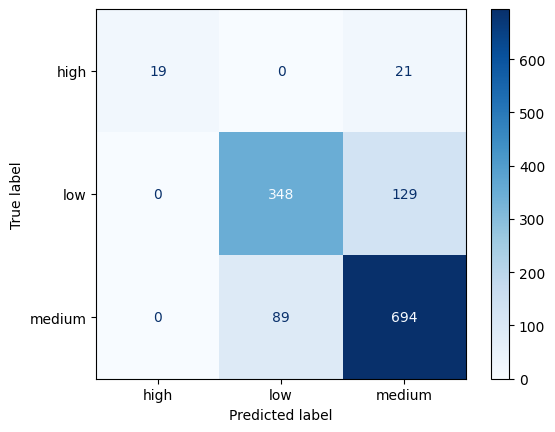

In [117]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.show()


The classification model achieves 82% accuracy, performing best at identifying the “medium” quality class, but tends to struggle with the “high” class because of the class imbalance still present after bucketing. Most misclassifications occur between “low” and “medium” classes, as shown by the confusion matrix.

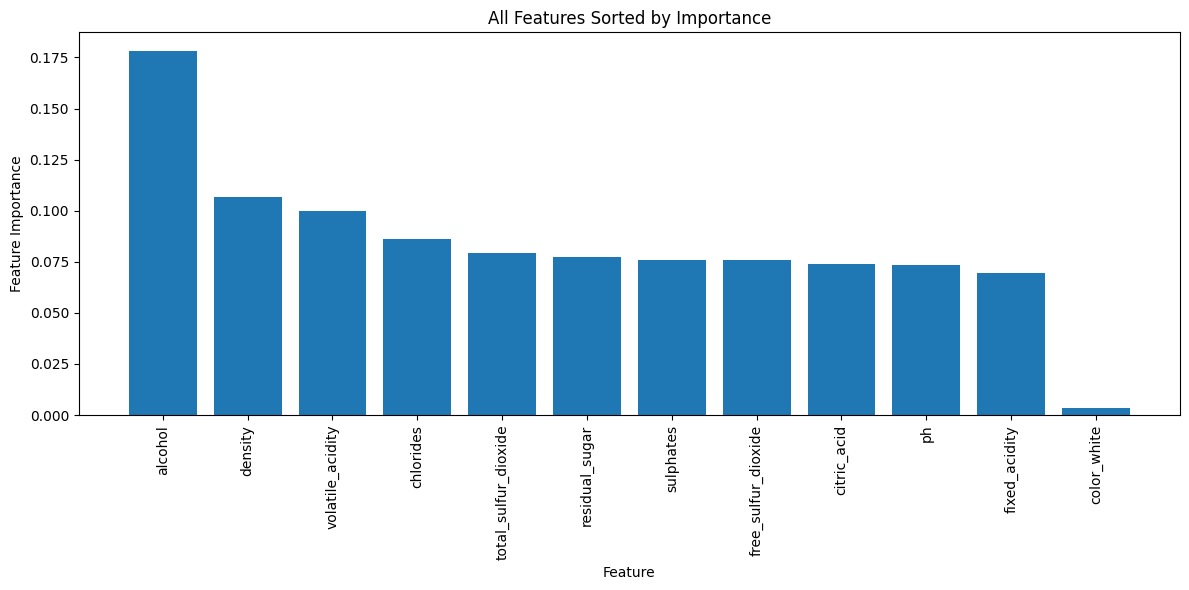

In [118]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 6
num_features = len(importances)

feature_names = X_train.columns.tolist()

top_n_indices = indices[:top_n]
top_features_names = [feature_names[i] for i in top_n_indices]
top_features_importances = importances[top_n_indices]

top_features_record = list(zip(top_features_names, top_features_importances))

plt.figure(figsize=(12, 6))

plt.bar(
    range(num_features),
    importances[indices],
    align='center'
)

plt.xticks(
    range(num_features),
    [feature_names[i] for i in indices],
    rotation=90
)

plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.title(f"All Features Sorted by Importance")

plt.tight_layout()
plt.show()


# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm

We plot the feature importance map as for the purpose of the PDP, ICE and ALE plots, considering the computational cost of these algorithms, it made sense to only perform them for the most important features that the model considers.

We hence only care about the top 6 features.

## **3. Explainations**

Plotting PDP, ICE and ALE to explain the models reasoning

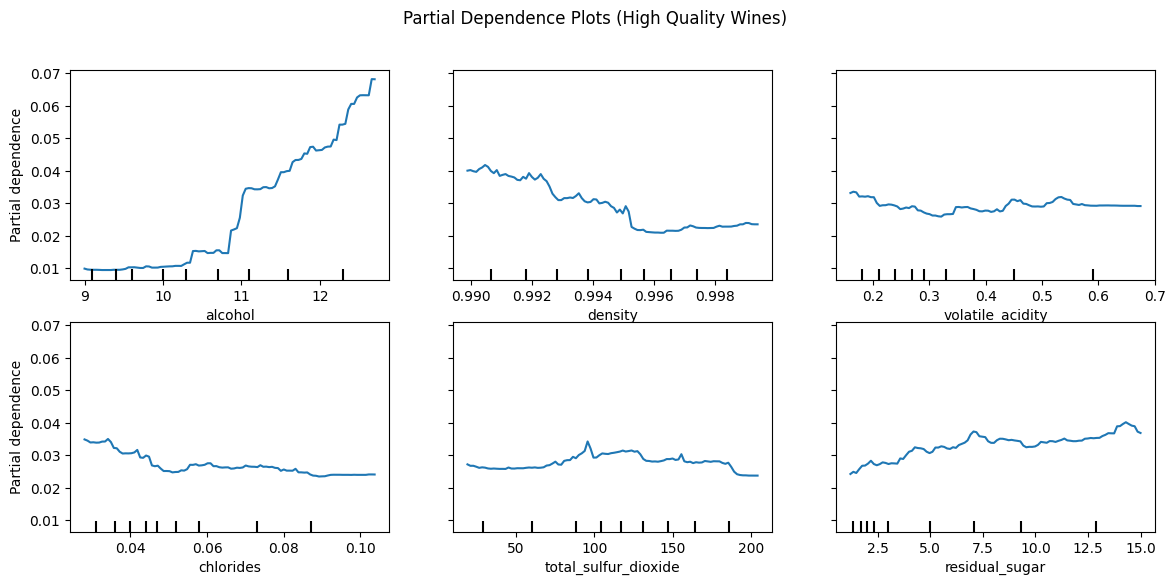

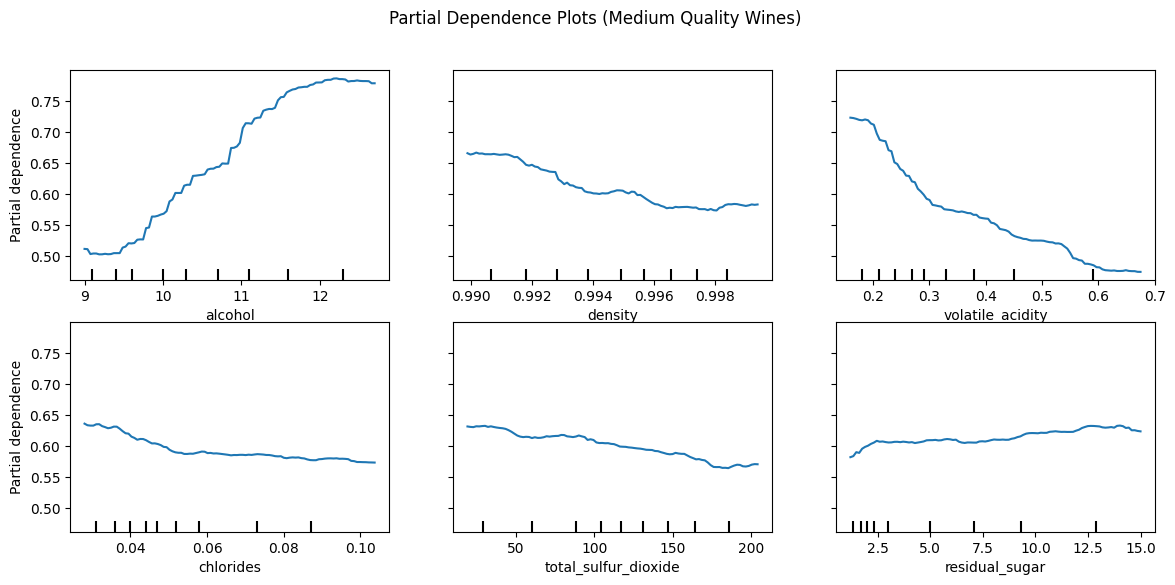

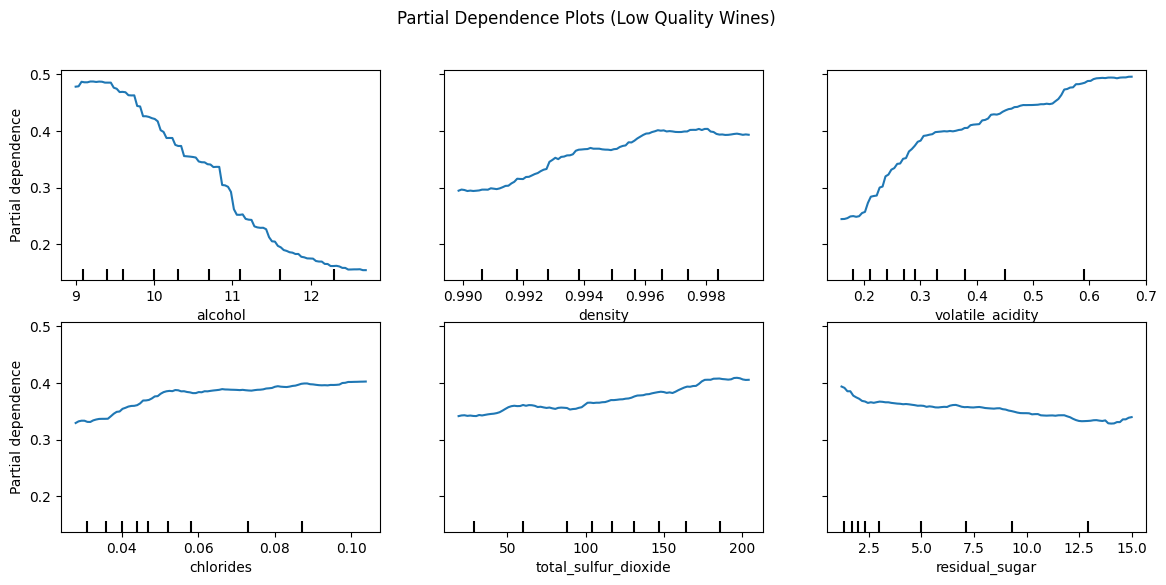

In [119]:
features_to_plot = top_features_names

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train, features_to_plot, ax=ax,
    target="high"
)
plt.suptitle("Partial Dependence Plots (High Quality Wines)")
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train, features_to_plot, ax=ax,
    target="medium"
)
plt.suptitle("Partial Dependence Plots (Medium Quality Wines)")
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train, features_to_plot, ax=ax,
    target="low"
)
plt.suptitle("Partial Dependence Plots (Low Quality Wines)")
plt.show()


# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm

**Alcohol:** Higher alcohol content increases the probability of a wine being medium or high quality, while lower alcohol is linked with lower quality.

**Density:** Wines with higher density are more likely to be classified as low quality; lower density supports medium or high quality classifications.

**Volatile Acidity:** Increased volatile acidity consistently raises the likelihood of a wine being low quality and decreases its chances of being medium or high quality.

**Chlorides:** Elevated chlorides are indicative of low quality wines, while lower chloride levels favor higher quality.

**Total Sulfur Dioxide:** Higher total sulfur dioxide points to low quality wine; reduced levels are associated with higher quality categories.

**Residual Sugar:** Higher residual sugar provides a modest lift to medium/high quality probability, while lower sugar slightly favors low quality.


Hence a high quality wine is most likely to have high alcohol, low density, and low volatile acidity, along with low levels of chlorides and total sulfur dioxide.

*Some parts of this explaination were refined with Perplexity on Sunday 09/28 at 9pm*

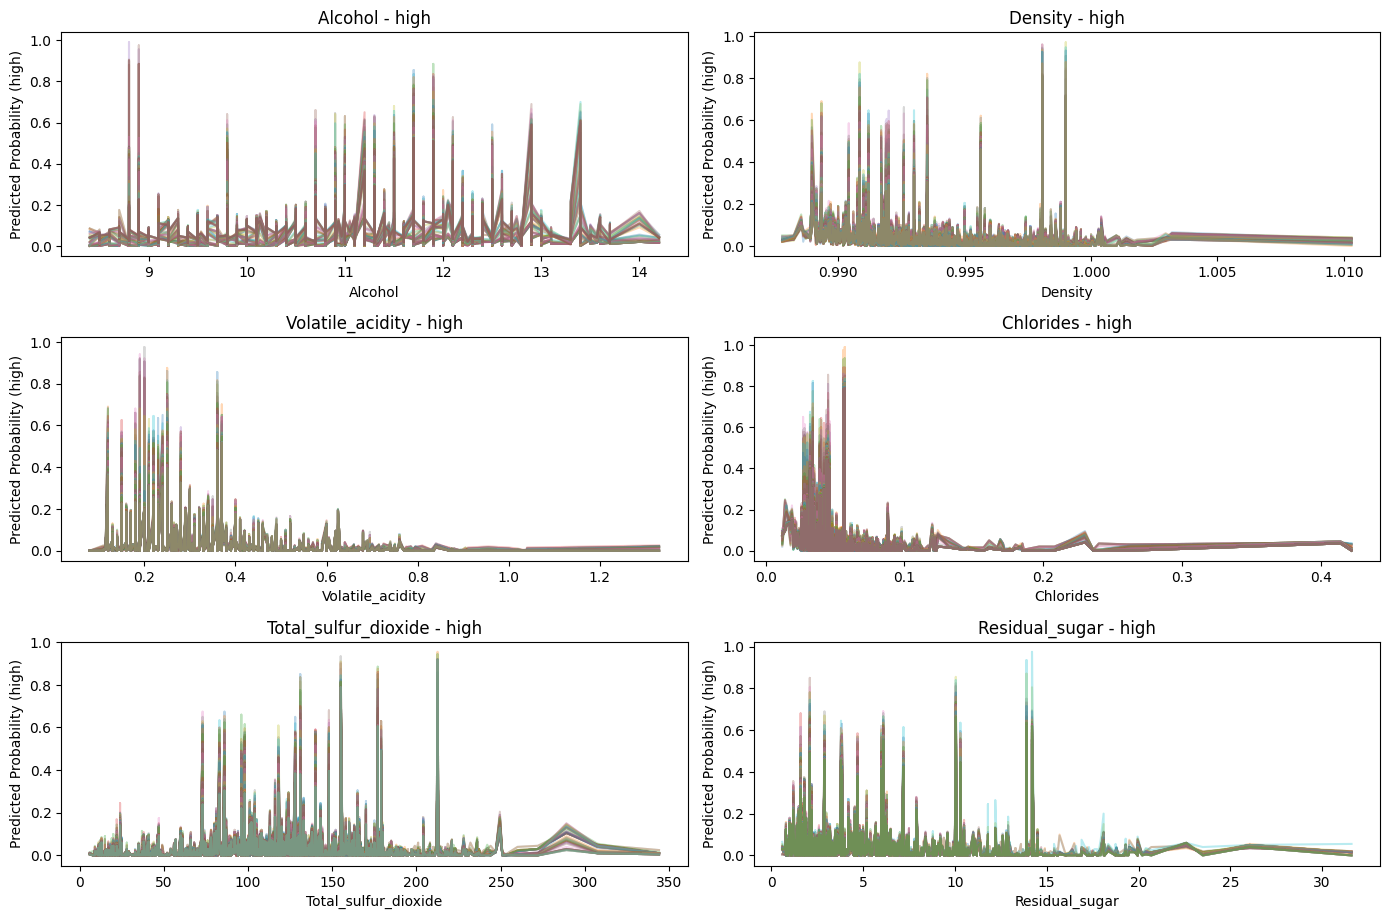

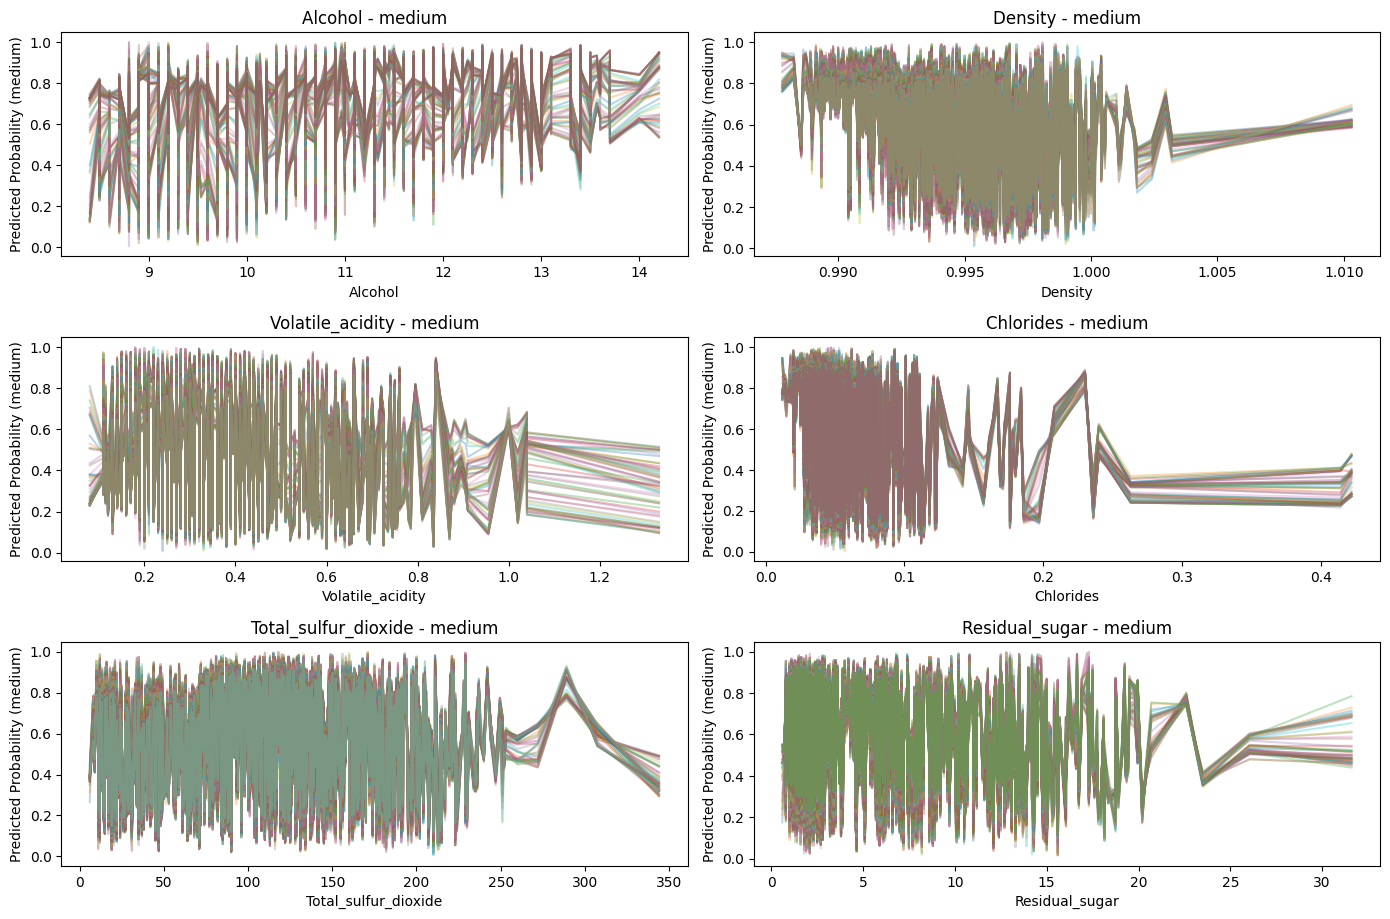

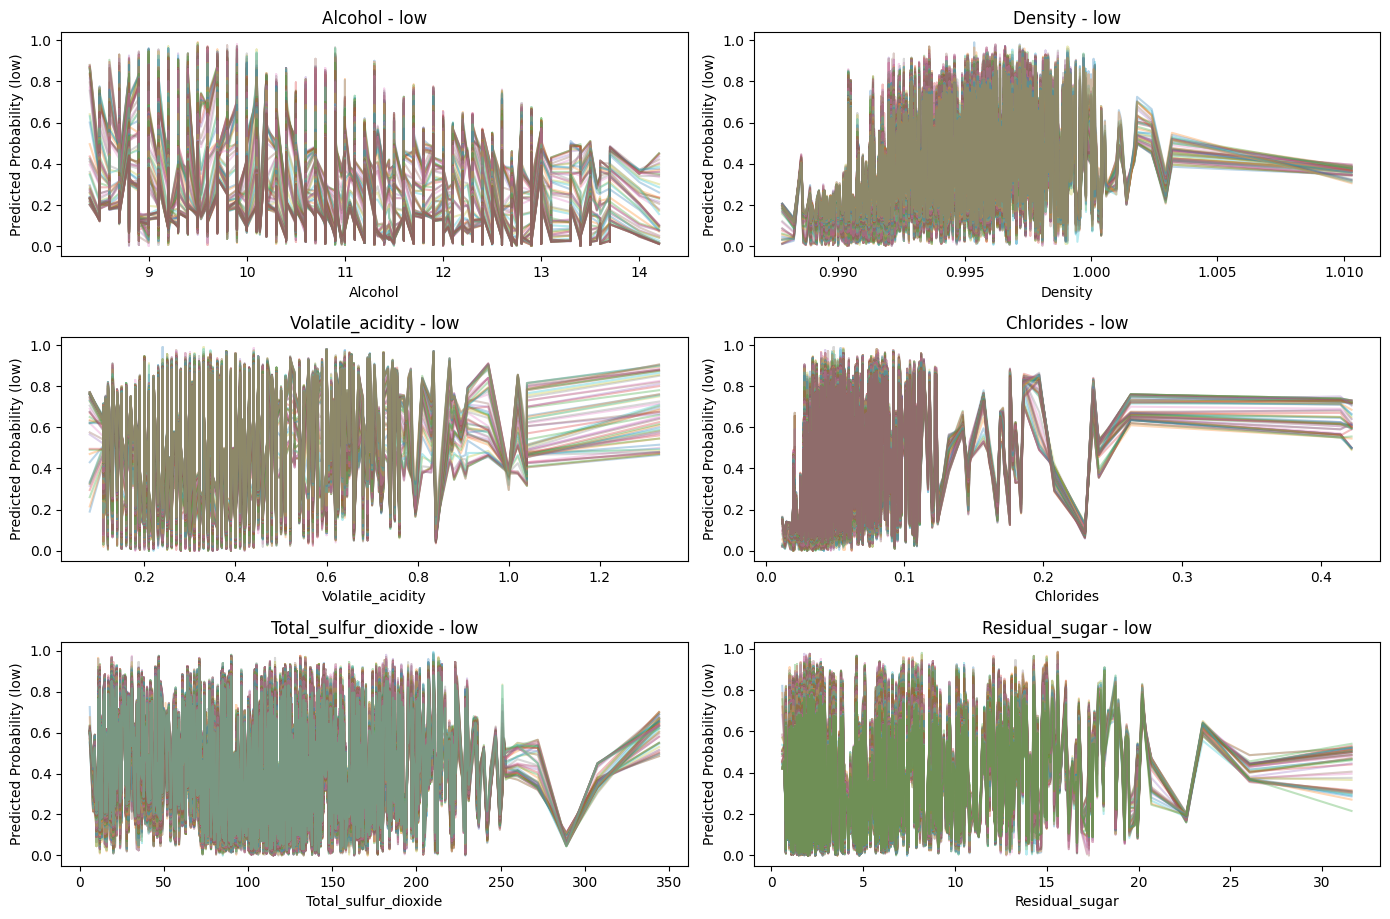

In [120]:
classes_of_interest = ["high","medium", "low"]

for class_name in classes_of_interest:
    class_index = list(model.classes_).index(class_name)
    class_label = model.classes_[class_index]

    n_features = len(features_to_plot)
    n_rows = 6
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
    axes = axes.flatten()  # Flatten so we can index easily

    for idx, feature in enumerate(features_to_plot):
        ice_data = ice(
            data=X_test,
            column=feature,
            predict=lambda X: model.predict_proba(X)[:, class_index]
        )

        # Handle MultiIndex vs normal columns
        if isinstance(ice_data.columns, pd.MultiIndex):
            feature_values = ice_data.columns.get_level_values(0).astype(float)
        else:
            feature_values = ice_data.columns.astype(float)

        n_samples = ice_data.shape[0]
        sample_indices = range(0, n_samples, max(1, n_samples // 50))

        ax = axes[idx]
        for i in sample_indices:
            ax.plot(feature_values, ice_data.iloc[i, :].values, alpha=0.3)

        ax.set_xlabel(feature.capitalize())
        ax.set_ylabel(f"Predicted Probability ({class_label})")
        ax.set_title(f"{feature.capitalize()} - {class_label}")

    # Remove empty subplots if features < n_rows*n_cols
    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm

The ICE plots reveal that while most wines show an increase in predicted high quality as alcohol rises (or as density, volatile acidity, chlorides, and total sulfur dioxide decrease), there is considerable variation in how strongly each wine responds. Some wines have sharp jumps or drops in predicted probability at certain feature values, indicating that the effect of a feature can be much stronger or weaker for specific samples compared to the average trend. This highlights that individual wines may have unique thresholds, and that model predictions are not uniform across all samples.

*Some parts of this explaination were refined with Perplexity on Sunday 09/28 at 9pm*

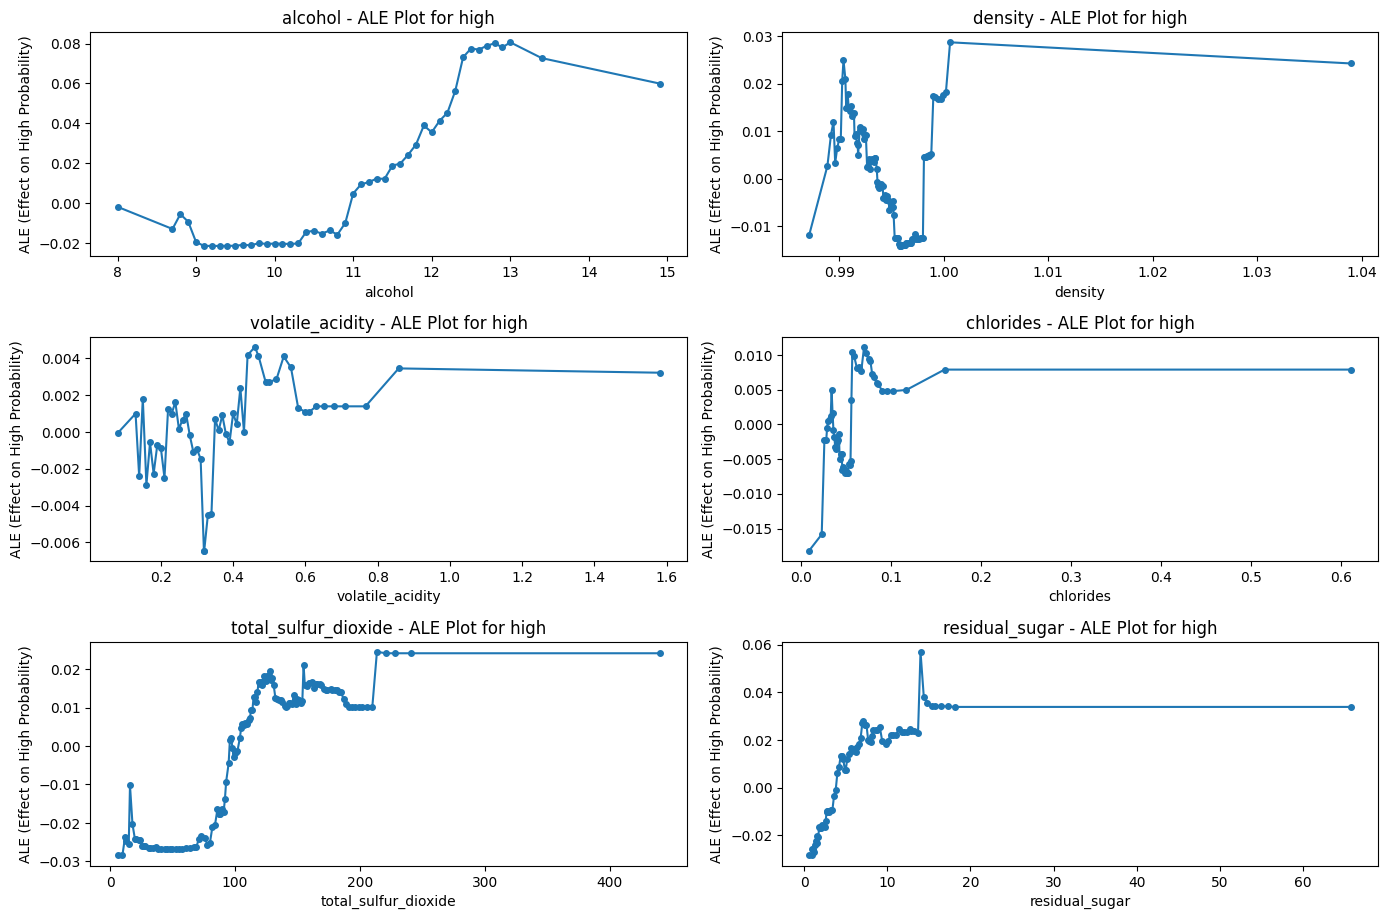

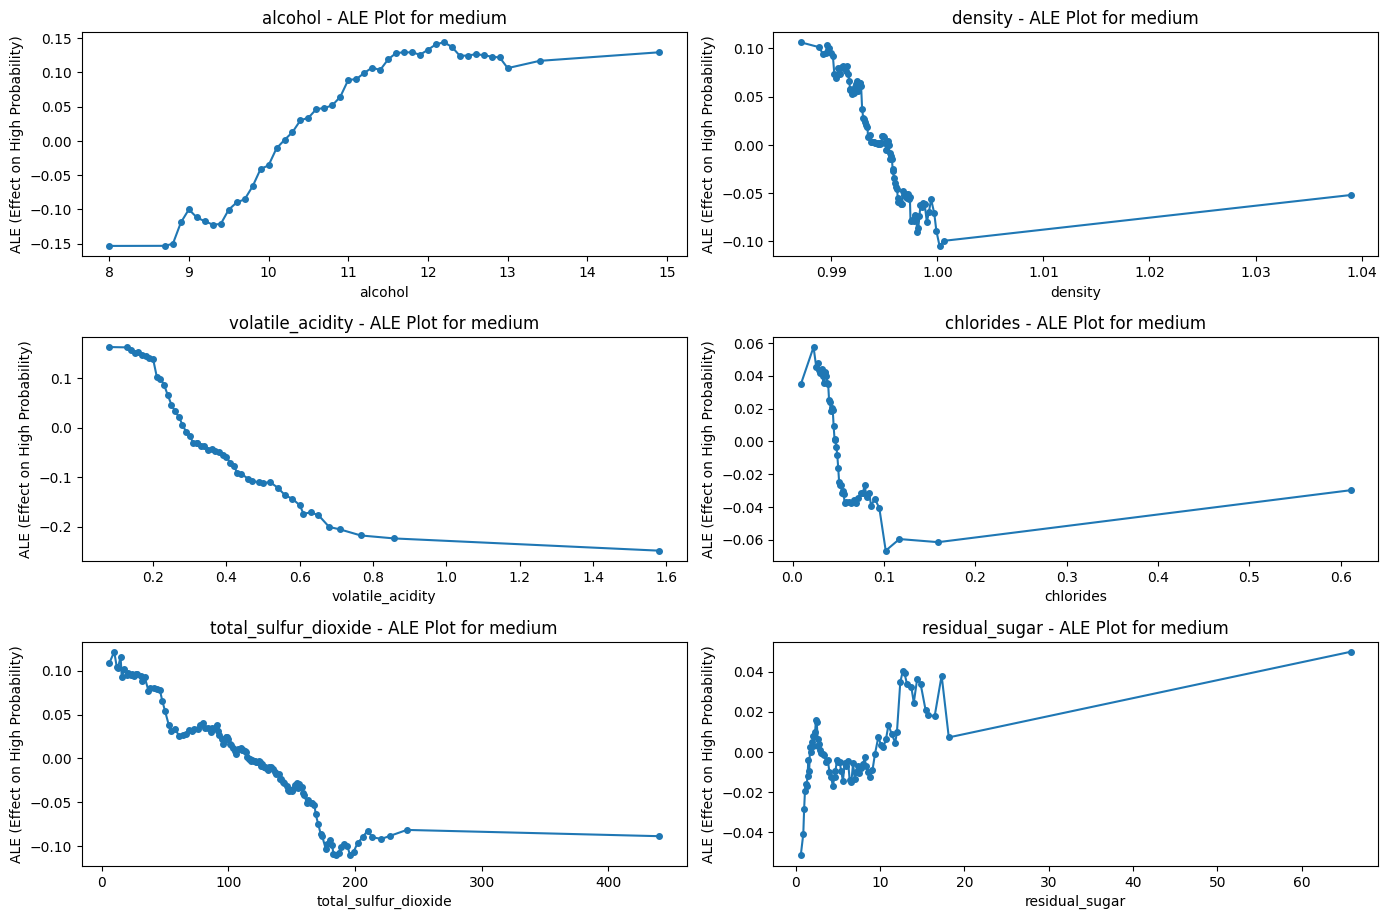

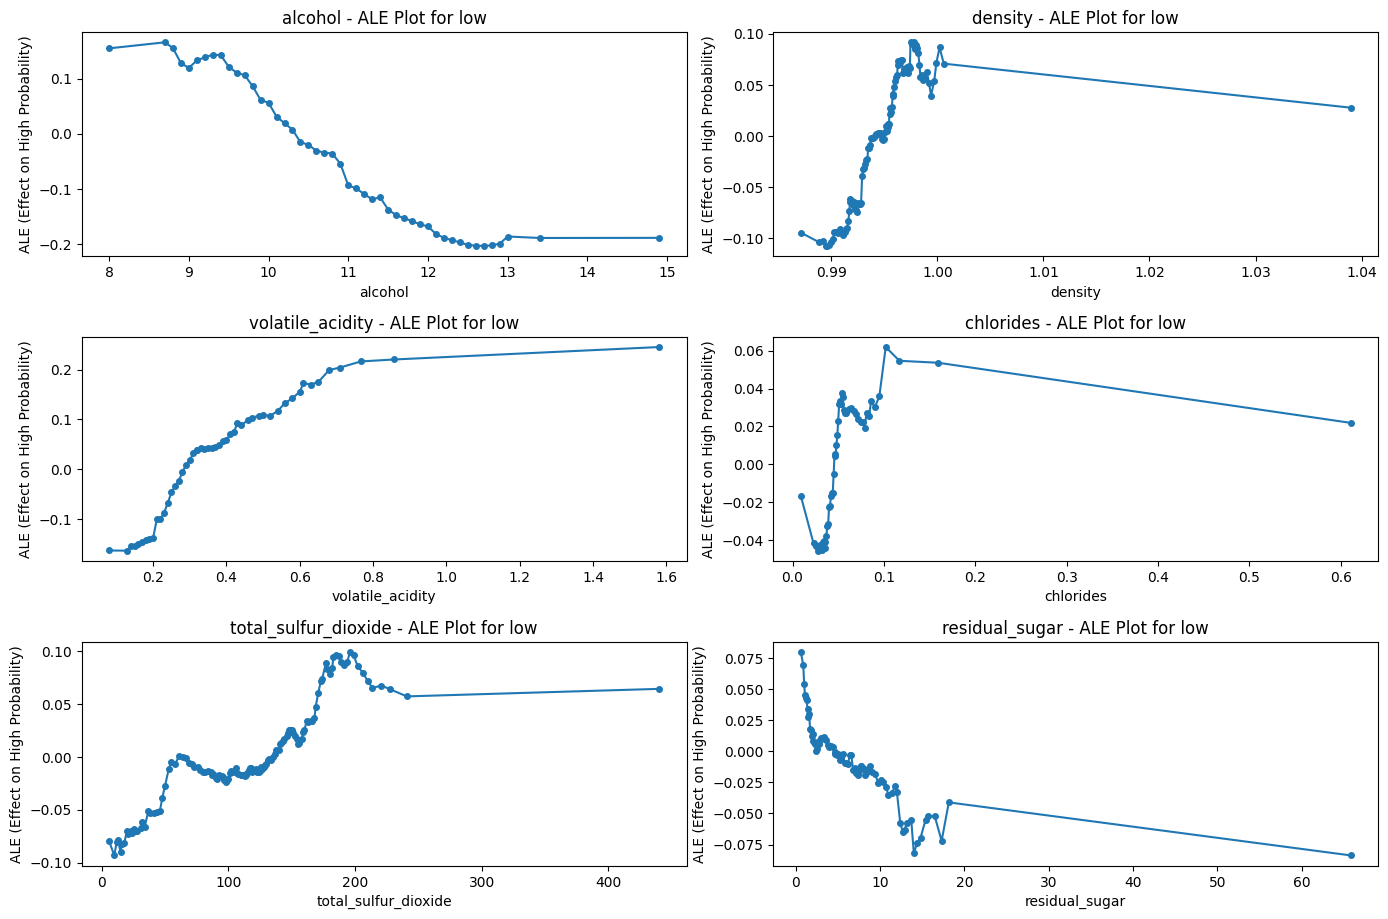

In [121]:
for class_name in classes_of_interest:
  X_train_array = X_train.values
  class_index = list(model.classes_).index(class_name)
  predict_high = lambda X: model.predict_proba(X)[:, class_index]

  ale = ALE(predict_high, feature_names=X_train.columns.tolist())
  ale_exp = ale.explain(X_train_array)

  n_features = len(features_to_plot)
  n_rows = 6
  n_cols = 2
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
  axes = axes.flatten()  # Flatten for easy indexing

  for idx, feature in enumerate(features_to_plot):
      feature_idx = X_train.columns.tolist().index(feature)
      ale_values = ale_exp.ale_values[feature_idx]
      feature_grid = ale_exp.feature_values[feature_idx]

      ax = axes[idx]
      ax.plot(feature_grid, ale_values, marker='o', markersize=4)
      ax.set_xlabel(f"{feature}")
      ax.set_ylabel("ALE (Effect on High Probability)")
      ax.set_title(f"{feature} - ALE Plot for {class_name}")

  # Remove any unused subplots
  for j in range(idx + 1, n_rows * n_cols):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

# Some parts of this code were debugged with ChatGPT and Gemini Pro on Sunday 09/28 at 9pm

**Alcohol:** The ALE plots show that
increasing alcohol content locally and consistently raises the probability of medium and high quality, and lowers the probability of low quality—very similar to the global trend seen in the PDP. However, ALE more accurately captures the effect in regions where the data is dense, avoiding the extrapolation issues that can affect PDP at the feature extremes.

**Density:** ALE plots confirm that lower density increases the probability of medium and high quality, and higher density favors low quality, just as the PDP suggests. The ALE, though, provides a more reliable estimate in the typical density range, especially if the data is unevenly distributed.

**Volatile Acidity:** Both ALE and PDP show that higher volatile acidity increases the chance of low quality and decreases the chance of medium/high quality. ALE, however, focuses on the local effect and can reveal if the impact is stronger or weaker in certain acidity intervals, rather than averaging over the whole range.

**Chlorides:** The ALE plot shows that higher chlorides locally increase the probability of low quality, matching the PDP’s overall trend. ALE is less influenced by outliers or rare values, so it gives a more trustworthy picture of the effect where most data points lie.

**Total Sulfur Dioxide:** ALE and PDP both indicate that higher sulfur dioxide is linked to low quality, but ALE highlights the effect in the most common value ranges, making the interpretation more robust to data sparsity.

**Residual Sugar:** The ALE plot shows a mild local increase in medium/high quality probability with higher residual sugar, similar to the PDP, but it may reveal subtle changes in effect strength across different sugar levels that the PDP averages out.


The correlation map reveals several moderate relationships between features, such as between free and total sulfur dioxide, fixed acidity and citric acid, and density and residual sugar. There is also a strong negative correlation between the “color_white” variable and features like sulphates, alcohol, and density, highlighting chemical differences between red and white wines.

These correlations suggest some degree of multicollinearity, but since most are not extreme, they have not significantly distorted the model’s results. Key features like alcohol, density, and volatile acidity remain strong and interpretable predictors of wine quality, and the patterns observed in the ALE, PDP, and ICE plots are consistent, indicating that the model is able to distinguish the individual effects of most features despite some overlap.

*Some parts of this explaination were refined with Perplexity on Sunday 09/28 at 9pm*